In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PLOTS_FOLDER = "../plots"

In [195]:
THRESH = 0.05

labels_df1 = pd.read_csv("../data/tatoeba_train_labels.csv", index_col=0)
feature_df1 = pd.read_csv(f"../data/tatoeba_tf_train_thresh{THRESH}.tsv", sep="\t", index_col=0)

labels_df1 = labels_df1.join(feature_df1)

del feature_df1

In [196]:
labels_df2 = pd.read_csv("../data/wm_labels.csv", index_col=0)
feature_df2 = pd.read_csv(f"../data/tatoeba_tf_train_thresh{THRESH}.tsv", sep="\t", index_col=0)

labels_df2 = labels_df2.join(feature_df2)

del feature_df2

In [197]:
df = pd.concat([labels_df1, labels_df2]).reset_index(drop=True)

Remove constant features

In [198]:
unique_cnts = df.nunique(axis=0)
const_feats = unique_cnts[unique_cnts == 1]

df.drop(const_feats.index.tolist(), axis=1, inplace=True)

In [199]:
X = df.drop("label", axis=1).astype(float)
y = (df.label == "hallucination").astype(float)

In [53]:
from sklearn.manifold import TSNE

In [54]:
tsne = TSNE(n_components=2, perplexity=35)

X_tsne = tsne.fit_transform(X)

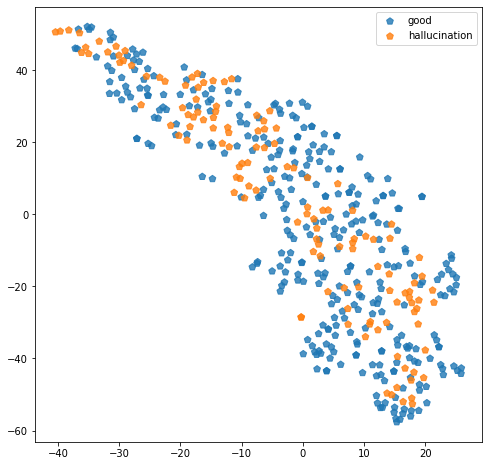

In [55]:
plt.figure(figsize=(8, 8))

colors = ["tab:blue", "tab:orange"]
labels = ["good", "hallucination"]

for i, (cls_name, clr) in enumerate(zip(labels, colors)):
    plt.scatter(
        X_tsne[y == i, 0], X_tsne[y == i, 1], 
        c=np.full((y == i).sum(), clr), 
        alpha=0.8,
        marker="p", s=50,
        label=cls_name
    )

plt.legend()

plt.show()

### Plot distributions

In [68]:
y_text = df.label
y_text[y_text == "context"] = "good"

/var/folders/18/0v6pzkhx2_v0c28pjmnp4ynh0000gn/T/ipykernel_15269/1543524555.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_text[y_text == "context"] = "good"


In [169]:
from scipy.stats import wasserstein_distance

In [189]:
def plot_distr(data, col, y, bin_cnt=20, outliers_quantile=None):
    plt.figure(figsize=(8, 6))
    
    data_good = data.loc[y == 0, col]
    data_hal = data.loc[y == 1, col]

    if outliers_quantile is not None:
        data_good = data_good[data_good <= data_good.quantile(outliers_quantile)]
        data_hal = data_hal[data_hal <= data_hal.quantile(outliers_quantile)]

    _, bins = np.histogram(data[col], bins=bin_cnt)
    plt.hist(data_good, bins, alpha=0.6, color="b", label="good")
    plt.hist(data_hal, bins, alpha=0.6, color="r", label="hallucination")

    kl_div = wasserstein_distance(data_good, data_hal)

    ax = plt.gca()
    ax.set(
        xlabel="Feature value", 
        ylabel="Count", 
        title=f"Feature {col}\nWasserstein distance: {kl_div:.4f}"
    )
    ax.legend()

In [190]:
from matplotlib.backends.backend_pdf import PdfPages

In [191]:
with PdfPages(os.path.join(PLOTS_FOLDER, "feature_distributions.pdf")) as pdf:
    for feature_name in X.columns:
        plot_distr(X, feature_name, y, bin_cnt=20)
        pdf.savefig()
        plt.close()

In [192]:
with PdfPages(os.path.join(PLOTS_FOLDER, "feature_distributions_no_outliers.pdf")) as pdf:
    for feature_name in X.columns:
        plot_distr(X, feature_name, y, bin_cnt=20, outliers_quantile=0.975)
        pdf.savefig()
        plt.close()

## Drop context errors

In [206]:
X_cut = X[df.label != "context"]
y_cut = y[df.label != "context"]

In [210]:
tsne = TSNE(n_components=2, perplexity=35)

X_tsne = tsne.fit_transform(X_cut)

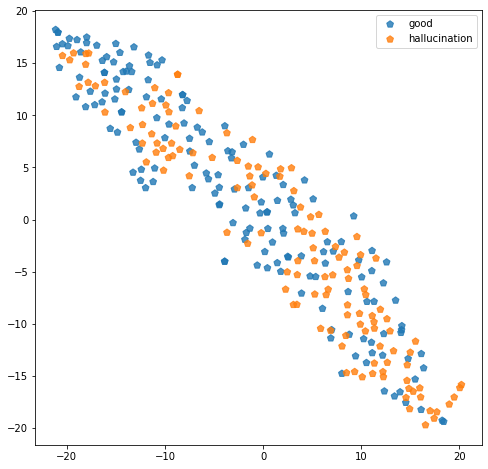

In [212]:
plt.figure(figsize=(8, 8))

colors = ["tab:blue", "tab:orange"]
labels = ["good", "hallucination"]

for i, (cls_name, clr) in enumerate(zip(labels, colors)):
    plt.scatter(
        X_tsne[y_cut == i, 0], X_tsne[y_cut == i, 1], 
        c=np.full((y_cut == i).sum(), clr), 
        alpha=0.8,
        marker="p", s=50,
        label=cls_name
    )

plt.legend()

plt.show()

In [213]:
with PdfPages(os.path.join(PLOTS_FOLDER, "feature_distributions_no_outliers_cut.pdf")) as pdf:
    for feature_name in X.columns:
        plot_distr(X, feature_name, y, bin_cnt=20, outliers_quantile=0.975)
        pdf.savefig()
        plt.close()

### Train CatBoost

In [224]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score

In [225]:
RANDOM_SEED = 0

In [222]:
X_cut = X_cut.values
y_cut = y_cut.values

In [226]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

rocs = []
accs = []
for train_split, test_split in kf.split(X_cut):
    X_train, X_test = X_cut[train_split], X_cut[test_split]
    y_train, y_test = y_cut[train_split], y_cut[test_split]

    clf = SVC(max_iter=10000).fit(X_train, y_train)
    preds = clf.predict(X_test)

    accs.append(accuracy_score(y_test, preds))

In [227]:
accs = np.array(accs)

accs.mean()

0.581063705435418

In [228]:
from getpass import getpass
import mlflow

os.environ["MLFLOW_TRACKING_USERNAME"] = "no-brainer"
os.environ["MLFLOW_TRACKING_PASSWORD"] = getpass("Enter your DAGsHub access token: ")

mlflow.set_tracking_uri("https://dagshub.com/no-brainer/tda-mt.mlflow")

In [229]:
with mlflow.start_run():
    mlflow.log_metric("accuracy", accs.mean())

    mlflow.log_param("experiment_type", "hallucinations")
    mlflow.log_param("model_type", "svm")
    mlflow.log_param("model max_iter", 10000)
    mlflow.log_param("model reg_coef", 1.0)
    mlflow.log_param("model kernel", "rbf")